# Technical Analysis

This notebook performs a backtest of the technical analysis trading agent. It evaluates the agent's decisions at various points in the historical data and calculates the cumulative return based on simulated trades.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import seaborn as sns
from mpl_finance import candlestick_ohlc # May need to install via !pip install mplfinance if not already
import io
import json
from PIL import Image as PILImage
from dotenv import load_dotenv
import os
import sys
from google import genai
from google.genai import types

# Adjust sys.path to import custom modules
# This assumes the notebook is in src/jupyter/technical_analyst/
# and the python module is in src/python/technical_analyst/
file_dir = os.getcwd()
if not file_dir in sys.path:
    sys.path.append(file_dir)
from plot_stock_analysis import plot_stock_analysis

c:\Users\User\workspace\stock-agent\.venv\Lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [3]:
# Load Environment Variables and Initialize GenAI Client
load_dotenv() # Assuming .env is in the project root

GOOGLE_API_KEY = os.getenv("GEMINI_API_KEY")
if not GOOGLE_API_KEY:
    print("GEMINI_API_KEY not found. Please set it in your .env file.")
else:
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    try:
        client = genai.Client(api_key=os.environ["GOOGLE_API_KEY"])
        print("Google GenAI Client initialized successfully.")
    except Exception as e:
        print(f"Error initializing Google GenAI Client: {e}")


Google GenAI Client initialized successfully.


In [4]:
# Agent's Image Description Function (copied from strategy_agent.ipynb)
def image_description(prompt: str, fig, client_instance):
    if not client_instance:
        print("GenAI client not initialized.")
        return None
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    pil_image = PILImage.open(buf)

    try:
        response = client_instance.models.generate_content(
            model="gemini-2.0-flash", # or the model you were using e.g. "gemini-1.5-flash"
            contents=[prompt, pil_image],
            config=types.GenerateContentConfig(
                temperature=0,
            ),
        )
        # print(f"Gemini response: {response.text}")
        return response.text
    except Exception as e:
        print(f"Error calling Gemini API: {e}")
        return None

In [5]:
# Agent's Prompt (copied from strategy_agent.ipynb)
symbol_for_prompt = "STOCK_SYMBOL" # This will be replaced by the actual symbol later
prompt_template = f"""
You are a professional stock analyst and expert in short-term trading strategies. Analyze the attached candlestick chart of the stock symbol '{{symbol}}'.
All of your analysis must be based solely on the chart provided — no external data or assumptions are allowed.

Your tasks are:
1. Identify short-term price trends and key chart patterns visible on the chart.
   - Clearly mark and describe support and resistance levels that have been **visibly tested multiple times** within the chart's timeframe (e.g., at least 2 touches or bounces).
   - Do not infer support/resistance levels that are **not shown** in the chart.
   - Identify the current trend (uptrend, downtrend, sideways) and estimate its strength.
   - Detect any notable chart patterns such as head and shoulders, double tops/bottoms, flags, or triangles, if present.

2. Recommend a trading strategy suitable for a short-term holding period (less than one month) based purely on the chart.

3. Provide specific actionable levels:
   - Action: (Buy / Sell / Hold)
   - Entry point: A price that is **within the chart and expected to be reached** within the next month based on current momentum, trend, and support/resistance.
   - Stop loss: A logical stop level based on visible chart structures. **if action is to buy stop loss must lower than entry point, if action is to sell stop loss must be higher than entry point.**
   - Take profit: A level based on resistance, previous highs, or chart patterns.
   - Confidence level: (Low, Medium, High) — based on clarity of pattern, volume, and alignment of indicators (e.g., SMA, RSI, MACD).

4. Explain your analysis in the clearest and most detailed way possible, without making any assumptions beyond what is visible in the chart.

5. Provide a concise summary of your analysis and final trading recommendation.

The output will be used as input for a `strategy_agent` to make decisions on the stock symbol '{{symbol}}'.

and return json output with the following keys:
- action
- entry_point
- stop_loss
- take_profit
- confidence
- analysis
- summary
"""

## Load and Prepare Data

Download historical stock data and prepare it by calculating necessary technical indicators like RSI and MACD.

In [6]:
# Configuration
symbol: str = "CPALL.BK"  # Example symbol, change as needed
start_date: str = "2023-01-01" # Using a longer history for more backtest points
# end_date is not needed as yfinance downloads up to the latest available

df_raw = yf.download(symbol, start=start_date)

if df_raw.empty:
    print(f"No data downloaded for symbol {symbol}. Exiting.")
else:
    print(f"Data downloaded for {symbol} from {df_raw.index.min()} to {df_raw.index.max()}")
    b_df = df_raw.reset_index().copy()
    b_df.columns = [col[0].lower() for col in b_df.columns] # Make columns lowercase and snake_case
    b_df.rename(columns={'adj_close': 'adjclose'}, inplace=True) # common rename
    b_df['ticker'] = symbol
    b_df.sort_values(by='date', ascending=True, inplace=True)
    b_df.reset_index(drop=True, inplace=True)

    # Convert date to datetime and add date_num for plotting if needed by plot_stock_analysis
    b_df['date'] = pd.to_datetime(b_df['date'])
    if 'date_num' not in b_df.columns: # plot_stock_analysis might expect 'date_num'
         b_df['date_num'] = b_df['date'].apply(mpl_dates.date2num)


    # Calculate RSI
    window = 14
    delta = b_df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    gain.fillna(0, inplace=True) # fillna for first row
    loss.fillna(0, inplace=True) # fillna for first row
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rs.replace([np.inf, -np.inf], np.nan, inplace=True) # handle division by zero if avg_loss is 0
    rs.fillna(method='bfill', inplace=True) # fill any remaining NaNs, e.g. if avg_loss was 0 for a period
    rs.fillna(0, inplace=True) # If all values were NaN (e.g. avg_loss consistently 0)
    b_df['rsi'] = 100 - (100 / (1 + rs))
    b_df['rsi'].fillna(50, inplace=True) # Fill initial NaNs in RSI with neutral 50

    # Calculate MACD
    exp1 = b_df['close'].ewm(span=12, adjust=False).mean()
    exp2 = b_df['close'].ewm(span=26, adjust=False).mean()
    b_df['macd'] = exp1 - exp2
    b_df['signal'] = b_df['macd'].ewm(span=9, adjust=False).mean()

    print("Data prepared with RSI and MACD.")
    print(b_df.head())
    print(f"Total data points: {len(b_df)}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data downloaded for CPALL.BK from 2023-01-03 00:00:00 to 2025-05-09 00:00:00
Data prepared with RSI and MACD.
        date      close       high        low       open    volume    ticker  \
0 2023-01-03  65.737206  65.737206  64.554882  64.791346  29888800  CPALL.BK   
1 2023-01-04  65.264275  66.210134  65.264275  65.973669  21285400  CPALL.BK   
2 2023-01-05  65.264275  65.973669  65.027810  65.500739  14858700  CPALL.BK   
3 2023-01-06  66.446602  67.155996  65.500743  65.737208  31641400  CPALL.BK   
4 2023-01-09  69.047714  69.757109  67.628926  67.628926  49965700  CPALL.BK   

   date_num        rsi      macd    signal  
0   19360.0   0.000000  0.000000  0.000000  
1   19361.0   0.000000 -0.037727 -0.007545  
2   19362.0   0.000000 -0.066855 -0.019407  
3   19363.0  71.428571  0.005403 -0.014445  
4   19366.0  88.888869  0.269449  0.042334  
Total data points: 572



C:\Users\User\AppData\Local\Temp\ipykernel_18136\1593314607.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rs.fillna(method='bfill', inplace=True) # fill any remaining NaNs, e.g. if avg_loss was 0 for a period
C:\Users\User\AppData\Local\Temp\ipykernel_18136\1593314607.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  b_df['rsi'].fillna(50, inplace=True) # Fill initial NaNs in RSI with neutral 50


## Backtesting Loop

Iterate through the dataset at specified intervals (indices 100, 150, ..., 600). For each interval:
1. Define `train_df` using data up to the current index.
2. Generate a stock chart image using `plot_stock_analysis` for `train_df`.
3. Get a trading decision (action, entry, SL, TP) from the Gemini agent based on the chart.
4. Define an `evaluation_df` for the 1-month period following the `train_df`.
5. Simulate the trade on `evaluation_df` and calculate the period return.
6. Store all period returns.

In [7]:

# Generate 20 random indices greater than 200
np.random.seed(42)  # For reproducibility
max_index = len(b_df) - 50  # Ensure we have some data left for evaluation
min_index = 200  # Minimum index as per requirement

if max_index <= min_index:
    print(f"Not enough data points. max_index={max_index}, min_index={min_index}")
    indices_to_test = [min_index]
else:
    possible_indices = list(range(min_index, max_index))
    num_samples = min(20, len(possible_indices))  # In case we have fewer than 20 possible indices
    indices_to_test = sorted(np.random.choice(possible_indices, size=num_samples, replace=False))

print(f"Testing on {len(indices_to_test)} random indices: {indices_to_test}")

all_period_returns = []
trade_details = [] # To store more info about each trade
result_figures = []  # Store figures for later review

actual_prompt = prompt_template.replace('{symbol}', symbol)

Testing on 20 random indices: [np.int64(205), np.int64(209), np.int64(225), np.int64(278), np.int64(284), np.int64(290), np.int64(304), np.int64(319), np.int64(326), np.int64(332), np.int64(358), np.int64(373), np.int64(385), np.int64(396), np.int64(397), np.int64(426), np.int64(456), np.int64(469), np.int64(481), np.int64(511)]



Processing backtest segment 1/20 (index: 404)
Evaluation_df from 2024-09-02 to 2024-09-30
Agent decision: Buy, Entry: 59.5
  BUY executed at 58.91 on 2024-09-02
  Exited at EOP 63.77. Return: 8.26%


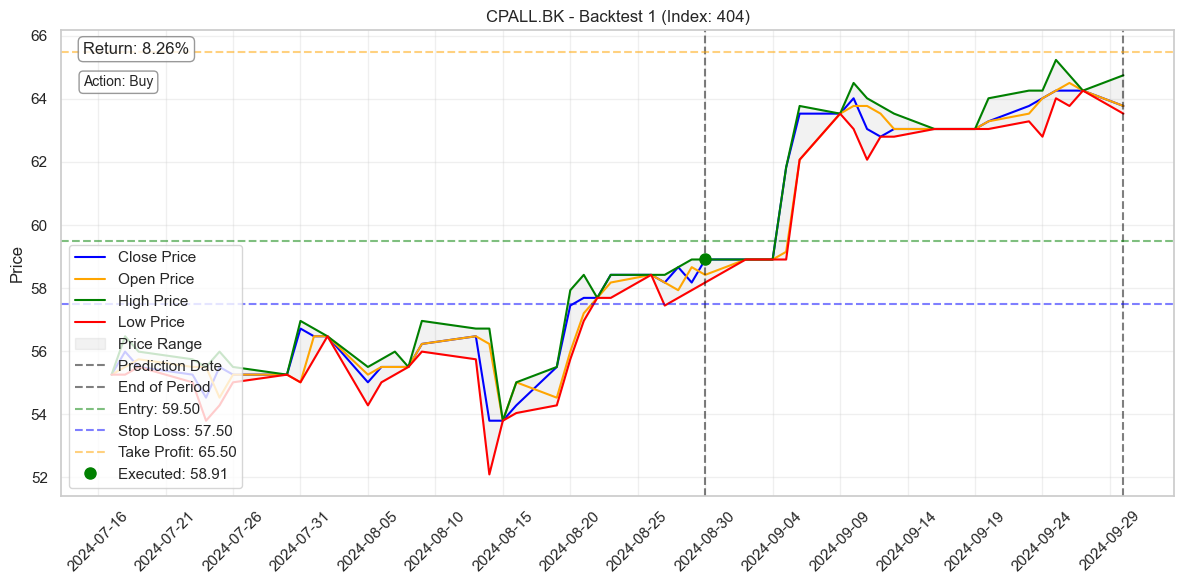


Processing backtest segment 2/20 (index: 406)
Evaluation_df from 2024-09-04 to 2024-10-03
Agent decision: Buy, Entry: 59.0
  BUY executed at 58.91 on 2024-09-04
  TP hit at 65.00. Return: 10.34%


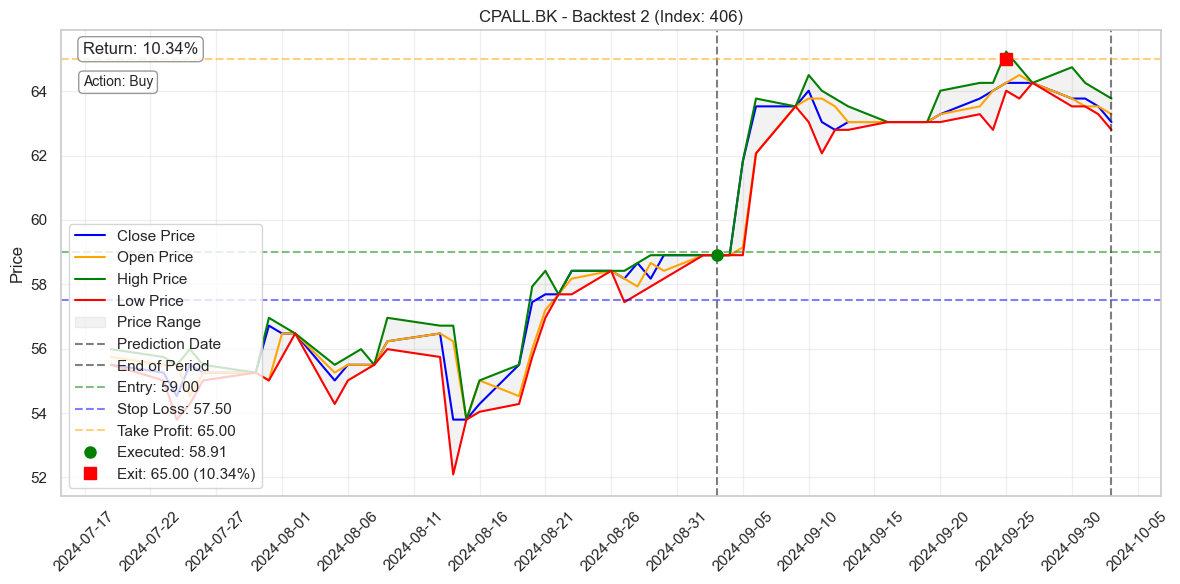


Processing backtest segment 3/20 (index: 408)
Evaluation_df from 2024-09-06 to 2024-10-04
Agent decision: Buy, Entry: 62.0
  Trade (buy) not executed as entry point 62.00 not met.

Processing backtest segment 4/20 (index: 410)
Evaluation_df from 2024-09-10 to 2024-10-09
Agent decision: Buy, Entry: 64.0
  BUY executed at 63.77 on 2024-09-10
  Exited at EOP 63.77. Return: -0.00%


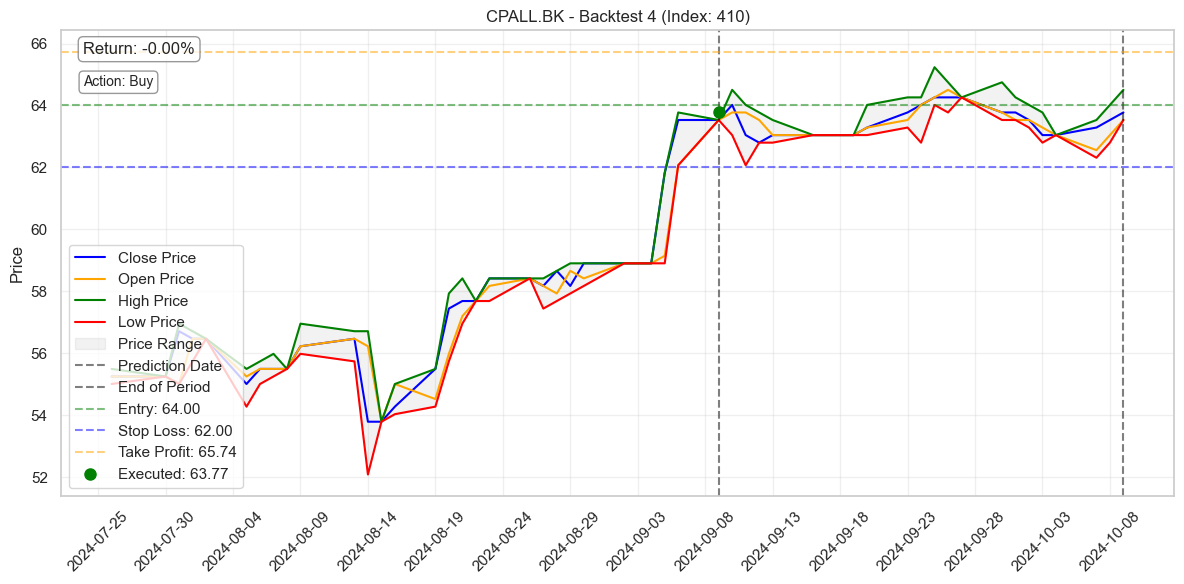


Processing backtest segment 5/20 (index: 415)
Evaluation_df from 2024-09-17 to 2024-10-16
Agent decision: Buy, Entry: 63.5
  BUY executed at 63.04 on 2024-09-17
  Exited at EOP 62.80. Return: -0.39%


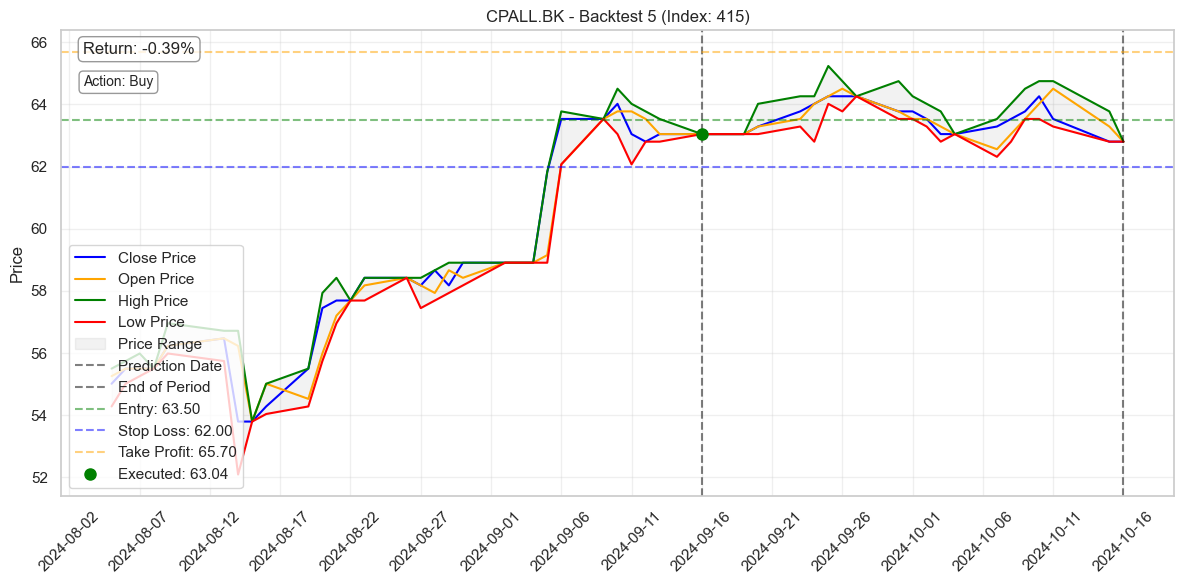


Processing backtest segment 6/20 (index: 424)
Evaluation_df from 2024-09-30 to 2024-10-25
Agent decision: BUY, Entry: 64.5
  BUY executed at 63.77 on 2024-09-30
  SL hit at 63.00. Return: -1.21%


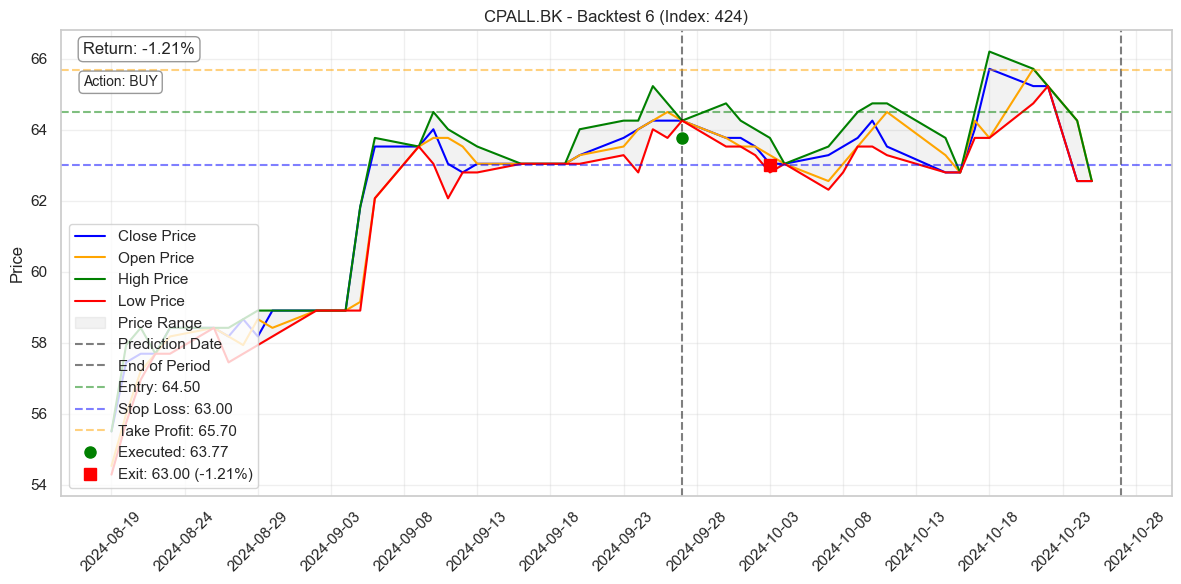


Processing backtest segment 7/20 (index: 425)
Evaluation_df from 2024-10-01 to 2024-10-30
Agent decision: Buy, Entry: 64.0
  BUY executed at 63.53 on 2024-10-01
  TP hit at 65.74. Return: 3.48%


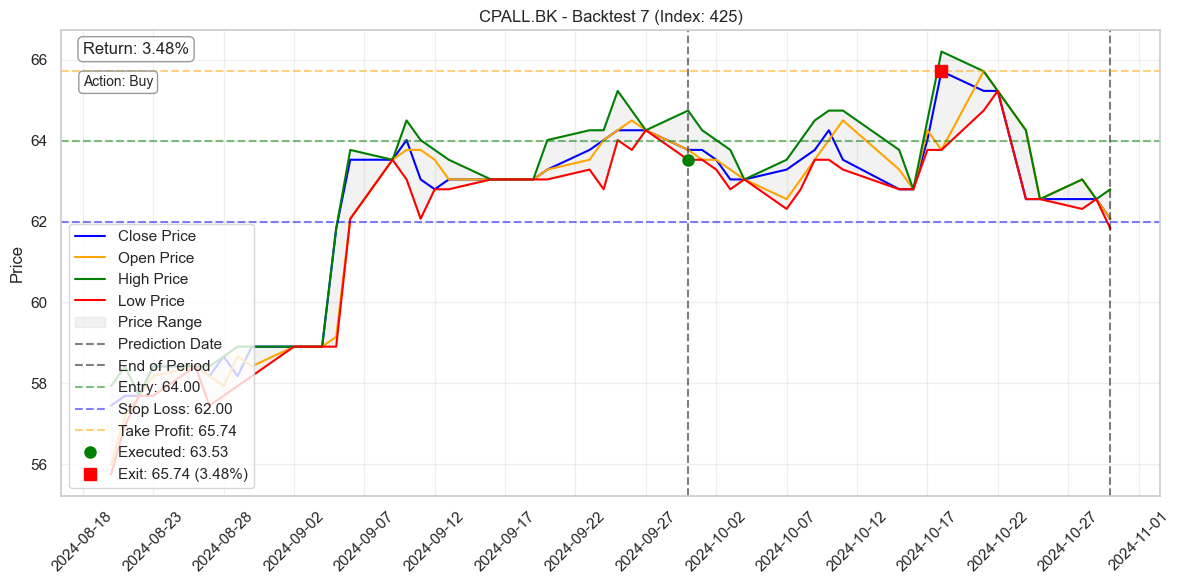


Processing backtest segment 8/20 (index: 446)
Evaluation_df from 2024-11-01 to 2024-11-29
Agent decision: Sell, Entry: 61.58
  SELL executed at 61.58 on 2024-11-01
  SL hit at 63.00. Return: -2.30%


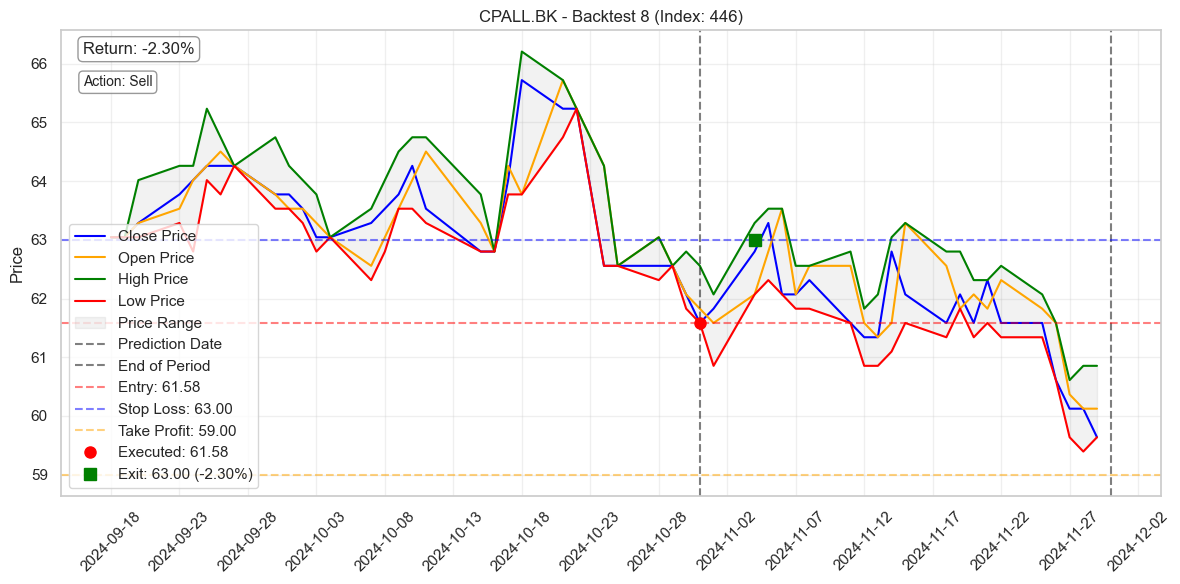


Processing backtest segment 9/20 (index: 449)
Evaluation_df from 2024-11-06 to 2024-12-04
Agent decision: Sell, Entry: 63.29
  SELL executed at 63.53 on 2024-11-06
  TP hit at 61.00. Return: 3.98%


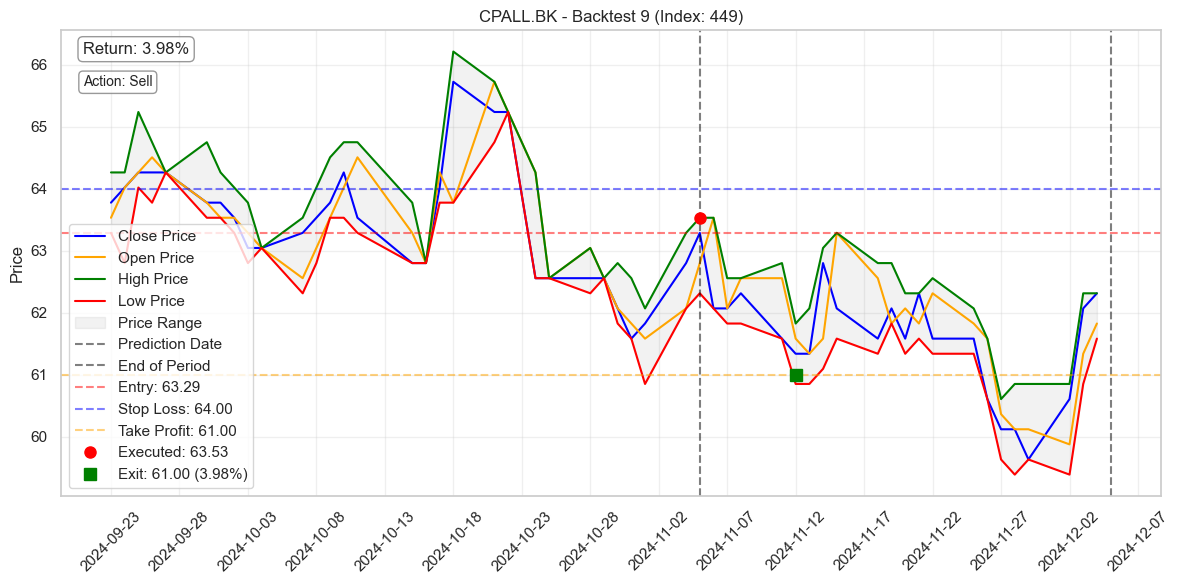


Processing backtest segment 10/20 (index: 451)
Evaluation_df from 2024-11-08 to 2024-12-06
Agent decision: Sell, Entry: 62.0
  SELL executed at 62.56 on 2024-11-08
  TP hit at 59.50. Return: 4.89%


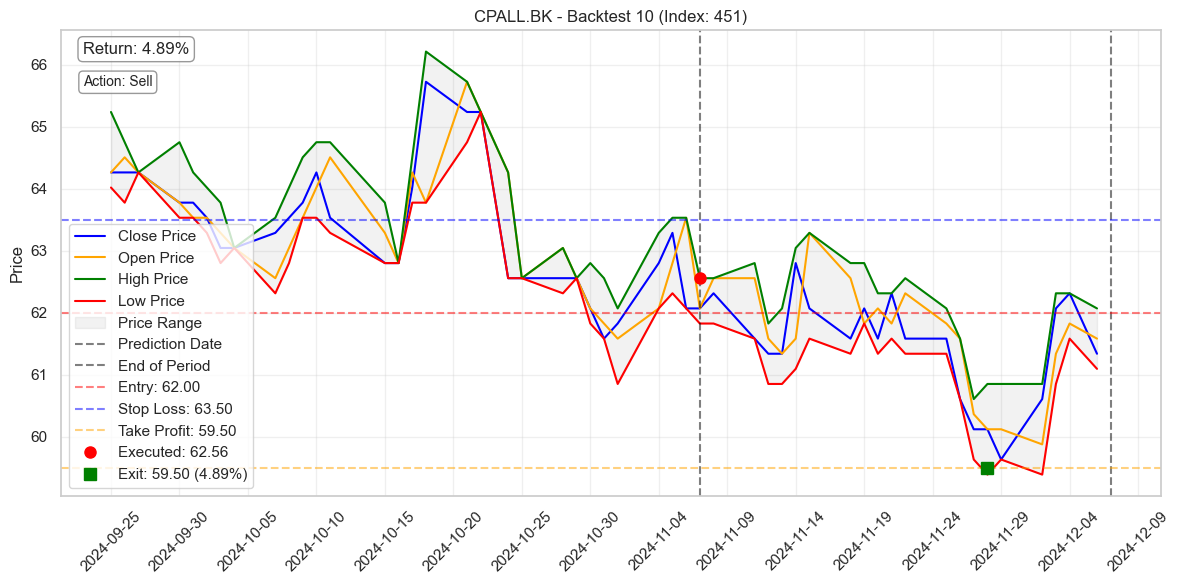


Processing backtest segment 11/20 (index: 458)
Evaluation_df from 2024-11-19 to 2024-12-18
Agent decision: Sell, Entry: 61.58
  SELL executed at 61.83 on 2024-11-19
  TP hit at 59.00. Return: 4.57%


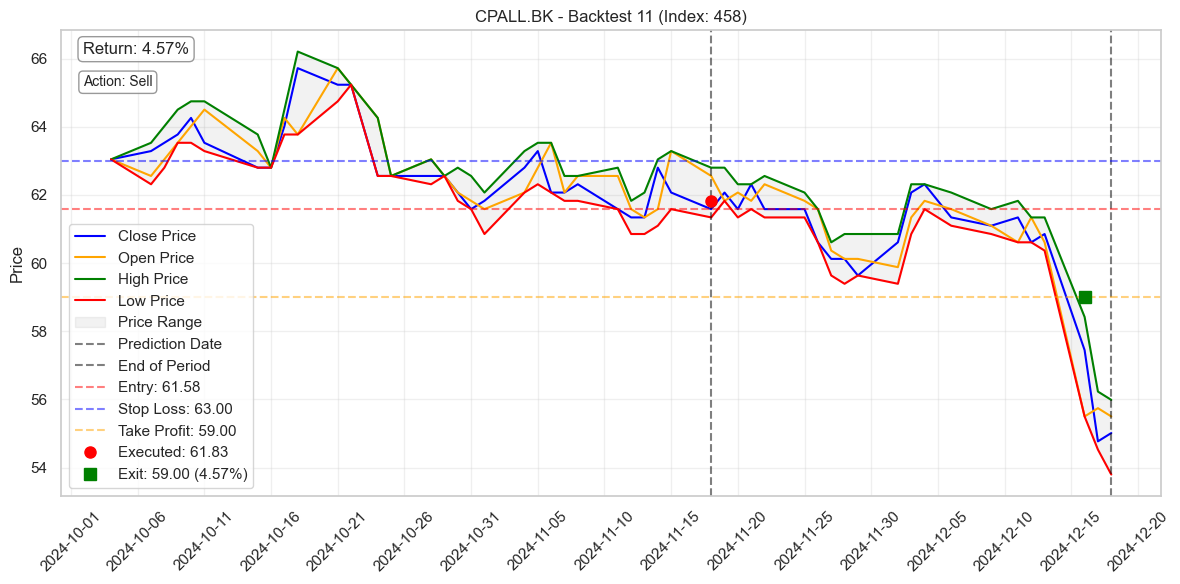


Processing backtest segment 12/20 (index: 470)
Evaluation_df from 2024-12-06 to 2025-01-03
Agent decision: Sell, Entry: 62.31
  Trade (sell) not executed as entry point 62.31 not met.

Processing backtest segment 13/20 (index: 475)
Evaluation_df from 2024-12-16 to 2025-01-13
Agent decision: Sell, Entry: 60.85
  Trade (sell) not executed as entry point 60.85 not met.

Processing backtest segment 14/20 (index: 480)
Evaluation_df from 2024-12-23 to 2025-01-20
Agent decision: Sell, Entry: 52.09
  SELL executed at 52.82 on 2024-12-23
  SL hit at 53.50. Return: -1.29%


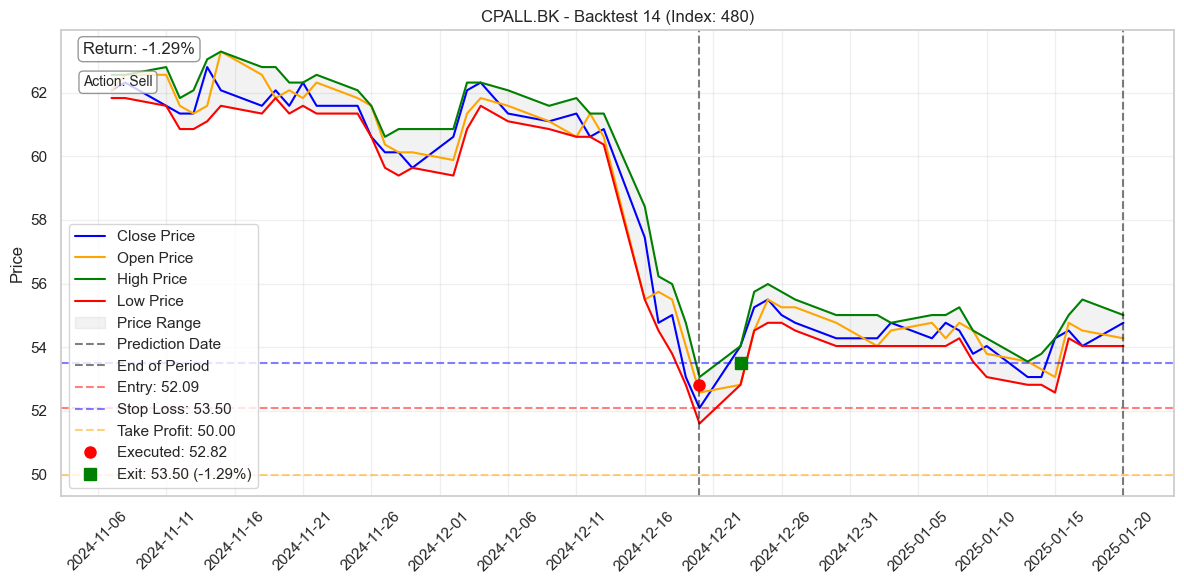


Processing backtest segment 15/20 (index: 481)
Evaluation_df from 2024-12-24 to 2025-01-23
Agent decision: Sell, Entry: 54.04
  SELL executed at 54.52 on 2024-12-24
  SL hit at 55.50. Return: -1.79%


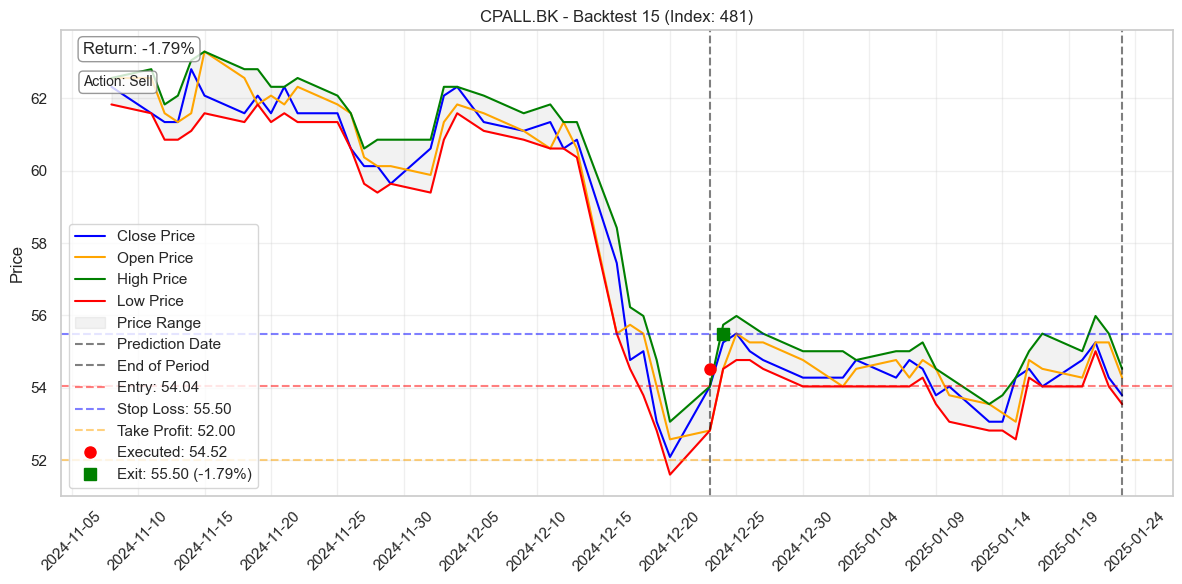


Processing backtest segment 16/20 (index: 488)
Evaluation_df from 2025-01-06 to 2025-02-03
Agent decision: Sell, Entry: 54.77
  SELL executed at 54.77 on 2025-01-06
  TP hit at 52.00. Return: 5.06%


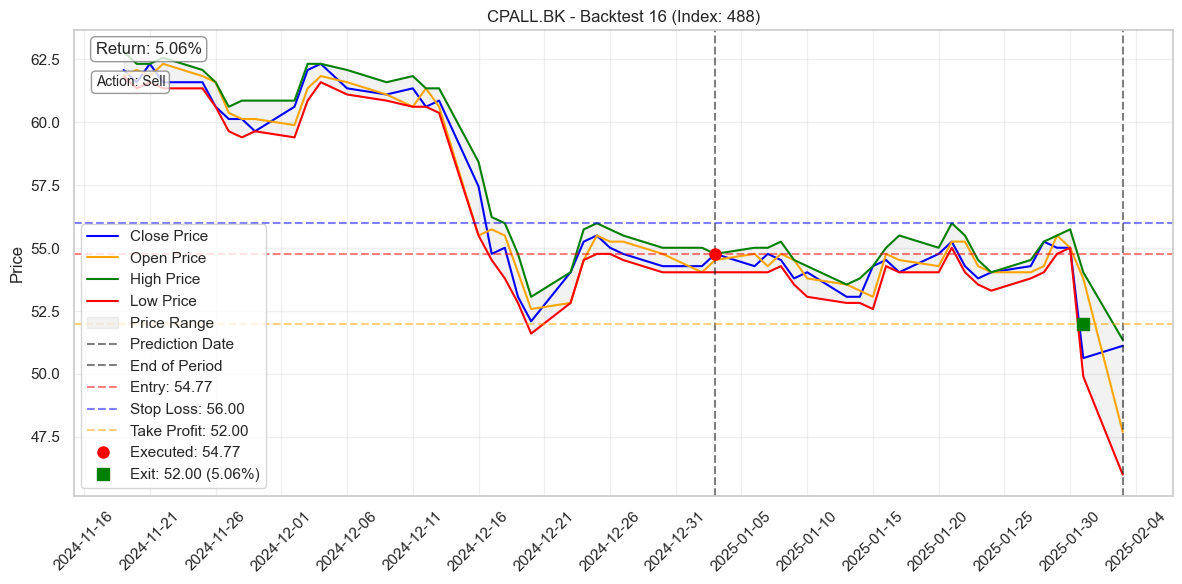


Processing backtest segment 17/20 (index: 496)
Evaluation_df from 2025-01-16 to 2025-02-14
Agent decision: Sell, Entry: 54.28
  SELL executed at 54.77 on 2025-01-16
  SL hit at 55.50. Return: -1.34%


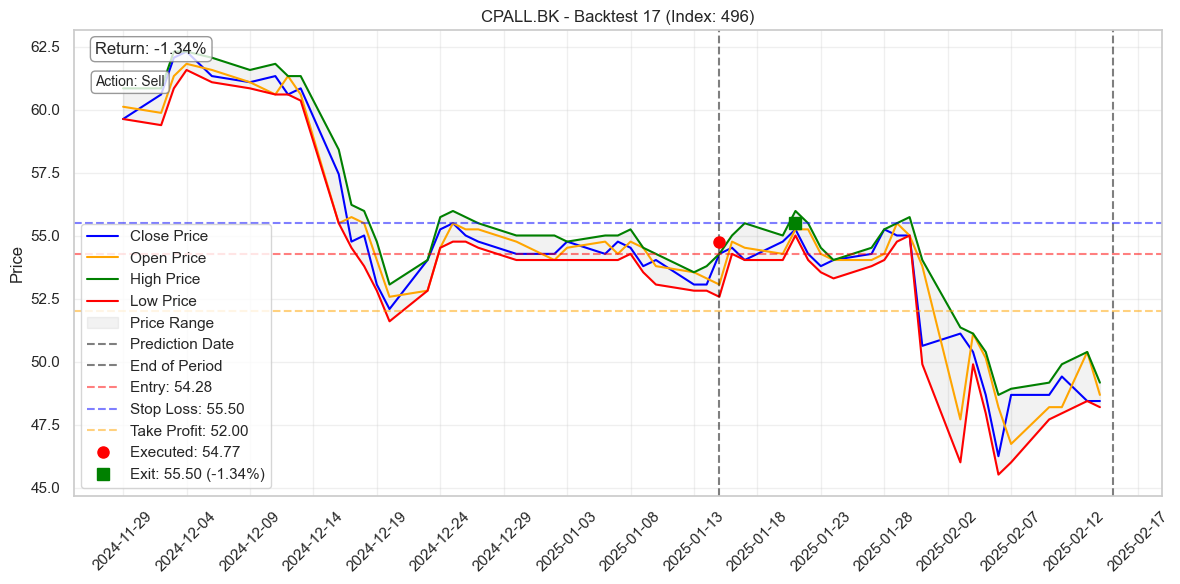


Processing backtest segment 18/20 (index: 514)
Evaluation_df from 2025-02-11 to 2025-03-10
Agent decision: Buy, Entry: 49
  BUY executed at 48.20 on 2025-02-11
  TP hit at 55.00. Return: 14.12%


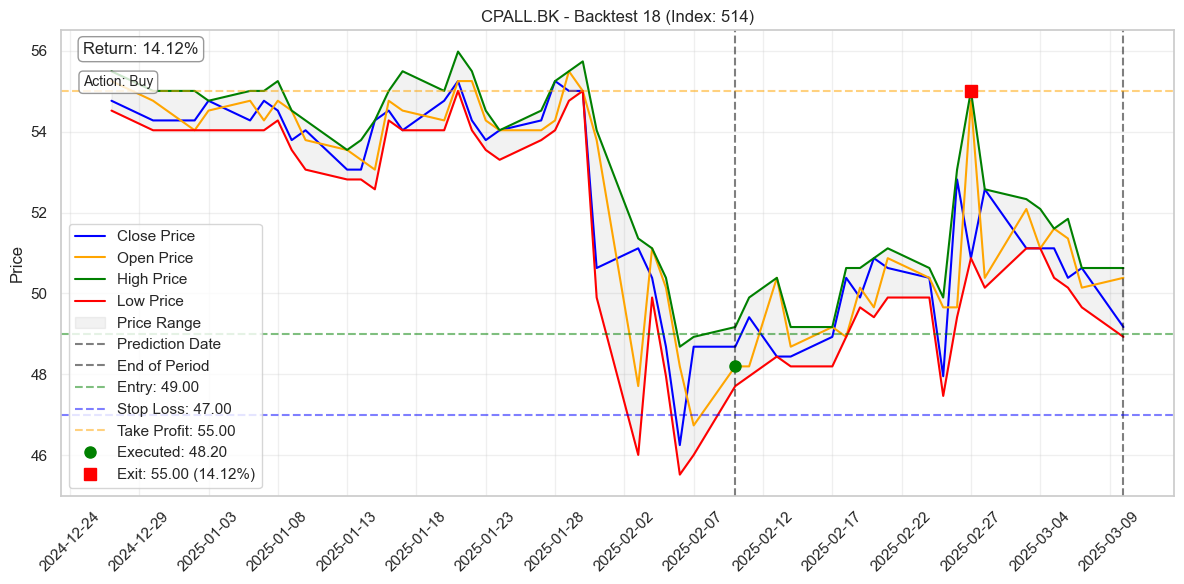


Processing backtest segment 19/20 (index: 515)
Evaluation_df from 2025-02-13 to 2025-03-11
Agent decision: Sell, Entry: 50
  SELL executed at 50.39 on 2025-02-13
  SL hit at 52.00. Return: -3.20%


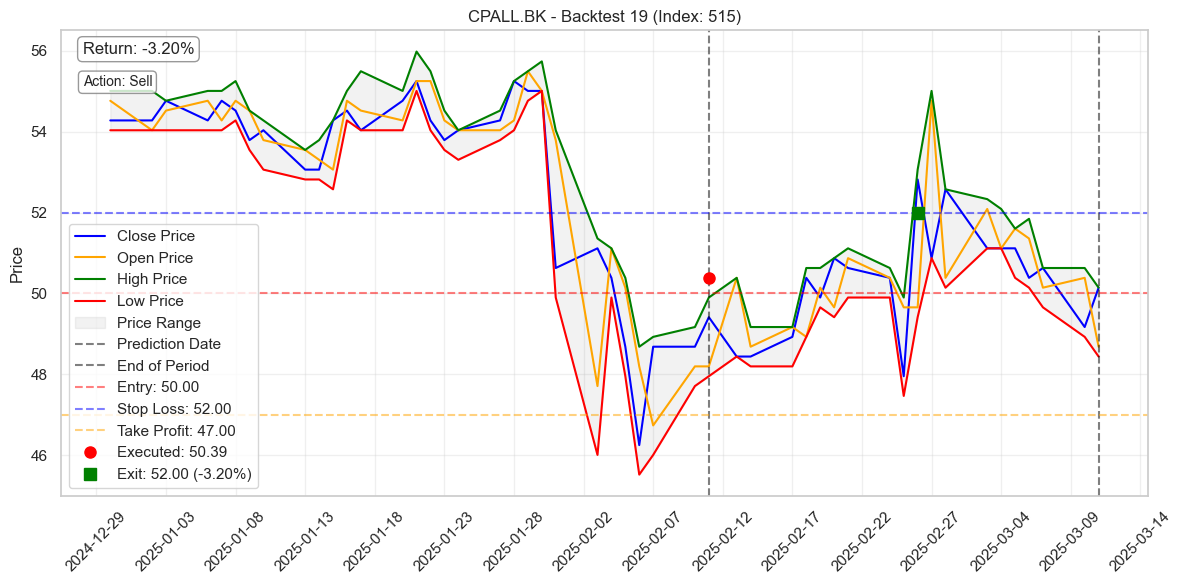


Processing backtest segment 20/20 (index: 519)
Evaluation_df from 2025-02-19 to 2025-03-18
Agent decision: Sell, Entry: 50.39
  SELL executed at 50.39 on 2025-02-19
  TP hit at 48.00. Return: 4.74%


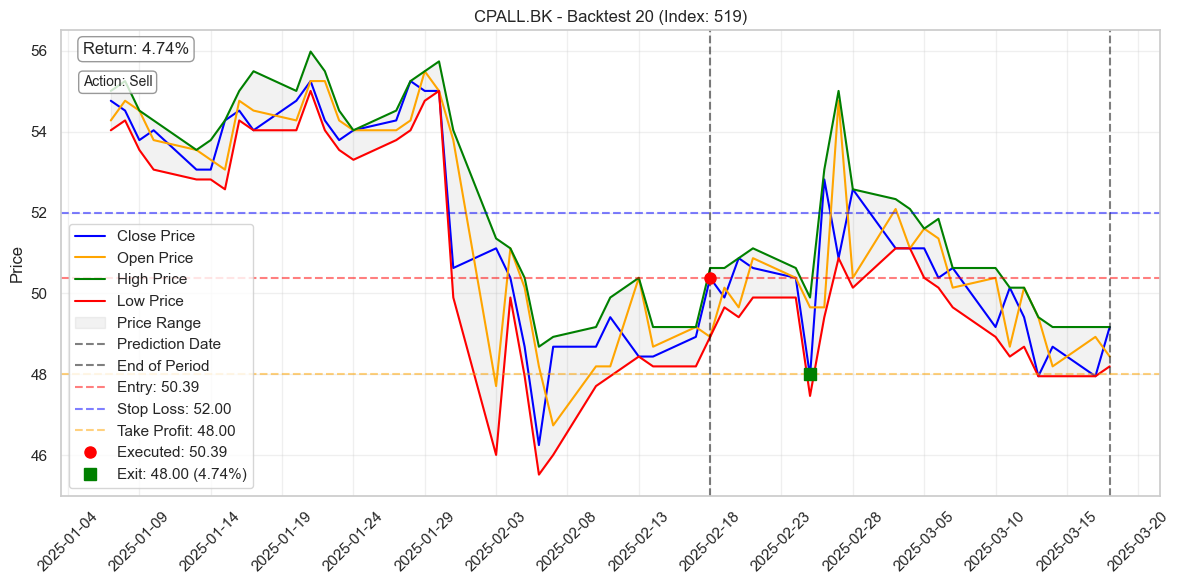


Backtesting loop finished.


In [8]:
if 'b_df' not in locals() or b_df.empty:
    print("b_df is not defined or empty. Cannot proceed with backtesting.")
else:
    # Generate 20 random indices greater than 200
    np.random.seed(99)  # For reproducibility
    max_index = len(b_df) - 50  # Ensure we have some data left for evaluation
    min_index = 400  # Minimum index as per requirement
    
    if max_index <= min_index:
        print(f"Not enough data points. max_index={max_index}, min_index={min_index}")
        indices_to_test = [min_index]
    else:
        possible_indices = list(range(min_index, max_index))
        num_samples = min(20, len(possible_indices))  # In case we have fewer than 20 possible indices
        indices_to_test = sorted(np.random.choice(possible_indices, size=num_samples, replace=False))
    
    # print(f"Testing on {len(indices_to_test)} random indices: {indices_to_test}")
    
    all_period_returns = []
    trade_details = [] # To store more info about each trade
    result_figures = []  # Store figures for later review

    actual_prompt = prompt_template.replace('{symbol}', symbol)

    for i, ind in enumerate(indices_to_test):
        print(f"\nProcessing backtest segment {i+1}/{len(indices_to_test)} (index: {ind})")
        if ind >= len(b_df):
            print(f"Index {ind} is out of bounds for b_df (length {len(b_df)}). Stopping backtest early.")
            break
        
        train_df = b_df.iloc[:ind].copy()
        if train_df.empty:
            print(f"Train_df is empty for index {ind}. Skipping.")
            continue

        if 'date_num' not in train_df.columns and 'date' in train_df.columns:
             train_df['date_num'] = train_df['date'].apply(mpl_dates.date2num)

        fig = plot_stock_analysis(train_df, symbol) # plot_stock_analysis should return a figure object
        
        # 2. Get decision from agent
        raw_response = image_description(actual_prompt, fig, client if 'client' in locals() else None)
        plt.close(fig) # Close the figure to free memory

        if raw_response is None:
            print("No response from agent. Skipping this segment.")
            all_period_returns.append(0) # Assume neutral outcome
            trade_details.append({'index': ind, 'action': 'error', 'reason': 'No agent response'})
            continue

        try:
            # Extract JSON part (robustly)
            json_start_index = raw_response.find('{')
            json_end_index = raw_response.rfind('}') + 1
            if json_start_index != -1 and json_end_index != -1 and json_start_index < json_end_index:
                 r_json_str = raw_response[json_start_index:json_end_index]
                 r_json = json.loads(r_json_str)
            else:
                raise json.JSONDecodeError("No JSON object found in response", raw_response, 0)
            
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON from agent response: {e}. Response was: \n{raw_response}")
            all_period_returns.append(0)
            trade_details.append({'index': ind, 'action': 'error', 'reason': 'JSON decode error'})
            continue
        except Exception as e:
            print(f"An unexpected error occurred parsing agent response: {e}")
            all_period_returns.append(0)
            trade_details.append({'index': ind, 'action': 'error', 'reason': f'Unexpected parse error: {e}'})
            continue


        # 3. Define evaluation period (next 1 month)
        evaluation_start_date = train_df['date'].iloc[-1]
        evaluation_end_date = pd.to_datetime(evaluation_start_date) + pd.DateOffset(months=1)
        evaluation_df = b_df[(b_df['date'] > evaluation_start_date) & (b_df['date'] <= evaluation_end_date)].copy()

        if evaluation_df.empty:
            print("Evaluation_df is empty. No trade simulation possible for this segment.")
            all_period_returns.append(0)
            trade_details.append({**{'index': ind}, **r_json, **{'sim_return': 0, 'sim_reason': 'No evaluation data'}})
            continue
        

        # 4. Simulate trade
        action = r_json.get('action', 'hold').lower()
        period_return = 0
        trade_executed = False
        exit_reason = "End of period"

        try:
            entry_price_agent = float(r_json.get('entry_point', 0))
            stop_loss_agent = float(r_json.get('stop_loss', 0))
            take_profit_agent = float(r_json.get('take_profit', 0))
        except (ValueError, TypeError) as e:
            print(f"Invalid price points from agent: {e}. Holding.")
            action = 'hold'
            

        actual_entry_price = 0
        if action == 'hold':
            indices_to_test.append(ind + 20) # Add next index to test more
            # print("  Action is HOLD. No trade executed.")
            continue    
        else:
            print(f"Evaluation_df from {evaluation_df['date'].iloc[0].date()} to {evaluation_df['date'].iloc[-1].date()}")
            print(f"Agent decision: {r_json.get('action')}, Entry: {r_json.get('entry_point')}")

        trade_log = {}
        if action == 'buy':
            for _, row in evaluation_df.iterrows():
                if not trade_executed and row['low'] <= entry_price_agent:
                    actual_entry_price = min(row['open'], entry_price_agent) # Enter at open or agent's price if gapped down
                    trade_executed = True
                    trade_log['entry_price'] = actual_entry_price
                    trade_log['entry_date'] = row['date']
                    print(f"  BUY executed at {actual_entry_price:.2f} on {row['date'].date()}")
                
                if trade_executed:
                    if row['high'] >= take_profit_agent:
                        period_return = (take_profit_agent - actual_entry_price) / actual_entry_price
                        exit_reason = f"Take Profit at {take_profit_agent:.2f}"
                        print(f"  TP hit at {take_profit_agent:.2f}. Return: {period_return:.2%}")
                        trade_log['exit_price'] = take_profit_agent
                        trade_log['exit_date'] = row['date']
                        break
                    elif row['low'] <= stop_loss_agent:
                        period_return = (stop_loss_agent - actual_entry_price) / actual_entry_price
                        exit_reason = f"Stop Loss at {stop_loss_agent:.2f}"
                        print(f"  SL hit at {stop_loss_agent:.2f}. Return: {period_return:.2%}")
                        trade_log['exit_price'] = stop_loss_agent
                        trade_log['exit_date'] = row['date']
                        break
            if trade_executed and period_return == 0: # Exited at end of period
                final_price = evaluation_df['close'].iloc[-1]
                period_return = (final_price - actual_entry_price) / actual_entry_price
                exit_reason = f"End of period at {final_price:.2f}"
                trade_log['exit_price'] = final_price
                trade_log['exit_date'] = evaluation_df['date'].iloc[-1]
                print(f"  Exited at EOP {final_price:.2f}. Return: {period_return:.2%}")

        elif action == 'sell': # Assuming short sell
            for _, row in evaluation_df.iterrows():
                if not trade_executed and row['high'] >= entry_price_agent:
                    actual_entry_price = max(row['open'], entry_price_agent) # Enter at open or agent's price if gapped up
                    trade_executed = True
                    trade_log['entry_price'] = actual_entry_price
                    trade_log['entry_date'] = row['date']
                    print(f"  SELL executed at {actual_entry_price:.2f} on {row['date'].date()}")

                if trade_executed:
                    if row['low'] <= take_profit_agent: # TP for short is a lower price
                        period_return = (actual_entry_price - take_profit_agent) / actual_entry_price
                        exit_reason = f"Take Profit at {take_profit_agent:.2f}"
                        trade_log['exit_price'] = take_profit_agent
                        trade_log['exit_date'] = row['date']
                        print(f"  TP hit at {take_profit_agent:.2f}. Return: {period_return:.2%}")
                        break
                    elif row['high'] >= stop_loss_agent: # SL for short is a higher price
                        period_return = (actual_entry_price - stop_loss_agent) / actual_entry_price
                        exit_reason = f"Stop Loss at {stop_loss_agent:.2f}"
                        trade_log['exit_price'] = stop_loss_agent
                        trade_log['exit_date'] = row['date']
                        print(f"  SL hit at {stop_loss_agent:.2f}. Return: {period_return:.2%}")
                        break
            if trade_executed and period_return == 0: # Exited at end of period
                final_price = evaluation_df['close'].iloc[-1]
                period_return = (actual_entry_price - final_price) / actual_entry_price
                exit_reason = f"End of period at {final_price:.2f}"
                trade_log['exit_price'] = final_price
                trade_log['exit_date'] = evaluation_df['date'].iloc[-1]
                print(f"  Exited at EOP {final_price:.2f}. Return: {period_return:.2%}")
        
        if not trade_executed and action != 'hold':
            print(f"  Trade ({action}) not executed as entry point {entry_price_agent:.2f} not met.")
            exit_reason = "Trade not triggered"
            continue
            
        all_period_returns.append(period_return)
        trade_details.append({
            **{'index': ind, 'train_end_date': evaluation_start_date.date()}, 
            **r_json, 
            **{'sim_return': period_return, 'sim_trade_executed': trade_executed, 'sim_exit_reason': exit_reason, 'sim_actual_entry': actual_entry_price if trade_executed else None}
        })

        # 5. Plot the results for this backtest segment
        test_df = evaluation_df.copy()
        start_date = train_df['date'].iloc[-1]
        month_later = pd.to_datetime(start_date) + pd.DateOffset(months=1)

        plot_df = pd.concat([train_df.iloc[-30:], test_df.iloc[:30]])  # Show last 30 days of train and first 30 days of test for better visualization
        plot_df['date'] = pd.to_datetime(plot_df['date'])
        plot_df.sort_values(by='date', ascending=True, inplace=True)


        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        ax.set_title(f"{symbol} - Backtest {i+1} (Index: {ind})")
        ax.set_ylabel("Price")
        ax.xaxis.set_major_formatter(mpl_dates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mpl_dates.DayLocator(interval=5))  # Show every 5 days
  
        ax.plot(plot_df['date'], plot_df['close'], label='Close Price', color='blue')
        ax.plot(plot_df['date'], plot_df['open'], label='Open Price', color='orange')
        ax.plot(plot_df['date'], plot_df['high'], label='High Price', color='green')
        ax.plot(plot_df['date'], plot_df['low'], label='Low Price', color='red')
        ax.fill_between(plot_df['date'], plot_df['low'], plot_df['high'], color='gray', alpha=0.1, label='Price Range')
        
        ax.axvline(x=start_date, linestyle='--', alpha=0.5, color='black', label='Prediction Date')
        ax.axvline(x=month_later, linestyle='--', alpha=0.5, color='black', label='End of Period')
        
        if r_json['action'].lower() == 'buy':
            entry_color = 'green'
            ax.axhline(y=float(r_json['entry_point']), linestyle='--', alpha=0.5, color=entry_color, 
                       label=f"Entry: {float(r_json['entry_point']):.2f}")
            ax.axhline(y=float(r_json['stop_loss']), linestyle='--', alpha=0.5, color='blue', 
                       label=f"Stop Loss: {float(r_json['stop_loss']):.2f}")
            ax.axhline(y=float(r_json['take_profit']), linestyle='--', alpha=0.5, color='orange', 
                       label=f"Take Profit: {float(r_json['take_profit']):.2f}")
            
            # Add execution point if trade was executed
            ax.plot(train_df['date'].iloc[-1], actual_entry_price, 'o', color=entry_color, markersize=8, 
                     label=f"Executed: {actual_entry_price:.2f}")
            # Add exit point if applicable
            if exit_reason.startswith("Take Profit") or exit_reason.startswith("Stop Loss"):
                exit_price = float(r_json['take_profit']) if exit_reason.startswith("Take Profit") else float(r_json['stop_loss'])
                ax.plot(trade_log['exit_date'], exit_price, 's', color='red', markersize=8, 
                         label=f"Exit: {exit_price:.2f} ({period_return:.2%})")
        elif r_json['action'].lower() == 'sell':
            entry_color = 'red'
            ax.axhline(y=float(r_json['entry_point']), linestyle='--', alpha=0.5, color=entry_color, 
                       label=f"Entry: {float(r_json['entry_point']):.2f}")
            ax.axhline(y=float(r_json['stop_loss']), linestyle='--', alpha=0.5, color='blue', 
                       label=f"Stop Loss: {float(r_json['stop_loss']):.2f}")
            ax.axhline(y=float(r_json['take_profit']), linestyle='--', alpha=0.5, color='orange', 
                       label=f"Take Profit: {float(r_json['take_profit']):.2f}")
            
            # Add execution point if trade was executed
            ax.plot(train_df['date'].iloc[-1], actual_entry_price, 'o', color=entry_color, markersize=8, 
                     label=f"Executed: {actual_entry_price:.2f}")
            # Add exit point if applicable
            if exit_reason.startswith("Take Profit") or exit_reason.startswith("Stop Loss"):
                exit_price = float(r_json['take_profit']) if exit_reason.startswith("Take Profit") else float(r_json['stop_loss'])
                ax.plot(trade_log['exit_date'], exit_price, 's', color='green', markersize=8, 
                         label=f"Exit: {exit_price:.2f} ({period_return:.2%})")
                
        # Add annotations for trade details
        ax.annotate(f"Return: {period_return:.2%}", 
                    xy=(0.02, 0.95), xycoords='axes fraction',
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        ax.annotate(f"Action: {r_json.get('action')}",
                    xy=(0.02, 0.88), xycoords='axes fraction',
                    fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower left')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
            
        
        # Store figure for later reference if needed
        result_figures.append(fig)
        plt.close(fig)

    print("\nBacktesting loop finished.")

## Calculate and Plot Cumulative Returns

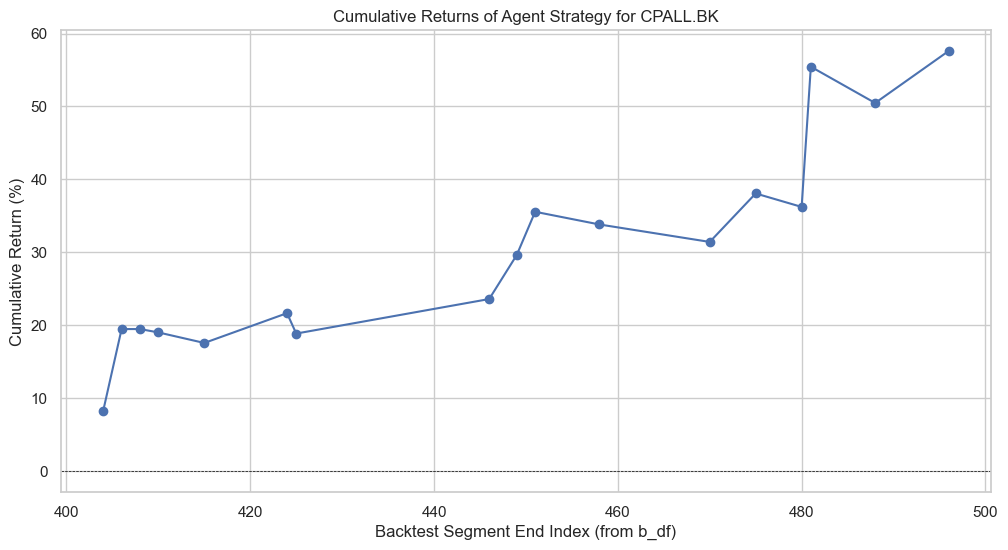

Final cumulative return: 57.61%

Trade Details:
    index train_end_date action  entry_point  stop_loss  take_profit  \
0     404     2024-08-30    Buy        59.50       57.5        65.50   
1     406     2024-09-03    Buy        59.00       57.5        65.00   
2     410     2024-09-09    Buy        64.00       62.0        65.74   
3     415     2024-09-16    Buy        63.50       62.0        65.70   
4     424     2024-09-27    BUY        64.50       63.0        65.70   
5     425     2024-09-30    Buy        64.00       62.0        65.74   
6     446     2024-10-31   Sell        61.58       63.0        59.00   
7     449     2024-11-05   Sell        63.29       64.0        61.00   
8     451     2024-11-07   Sell        62.00       63.5        59.50   
9     458     2024-11-18   Sell        61.58       63.0        59.00   
10    480     2024-12-20   Sell        52.09       53.5        50.00   
11    481     2024-12-23   Sell        54.04       55.5        52.00   
12    488     20

In [9]:
if not all_period_returns:
    print("No period returns were calculated. Cannot plot cumulative returns.")
else:
    # Ensure all returns are numeric, default to 0 if not (e.g. from errors)
    numeric_period_returns = [r if isinstance(r, (int, float)) else 0 for r in all_period_returns]
    
    cumulative_returns = np.cumprod(1 + np.array(numeric_period_returns)) - 1
    
    plt.figure(figsize=(12, 6))
    plt.plot(indices_to_test[:len(cumulative_returns)], cumulative_returns * 100, marker='o', linestyle='-')
    plt.title(f'Cumulative Returns of Agent Strategy for {symbol}')
    plt.xlabel('Backtest Segment End Index (from b_df)')
    plt.ylabel('Cumulative Return (%)')
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
    plt.show()

    print(f"Final cumulative return: {cumulative_returns[-1]*100:.2f}%")

    # Display trade details
    trade_details_df = pd.DataFrame(trade_details)
    print("\nTrade Details:")
    # display(trade_details_df) # Use display in Jupyter environment for better formatting
    print(trade_details_df)


## Conclusion

This section would summarize the findings from the backtest, discussing the overall performance, consistency, and any observed patterns in the agent's decisions and outcomes.
Based on the cumulative return plot and trade details, an assessment of the strategy's viability can be made.